# Coin Metrics Python API Client Walkthrough (Community Version)

This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client using the Community Version.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

## Resources
To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Knowledge Base](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.

## Setup

In [1]:
from os import environ
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import json
import logging
from pytz import timezone as timezone_conv
from datetime import timezone as timezone_info

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,8)})


In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")


client = CoinMetricsClient(api_key)

2021-11-12 10:13:21 INFO     API key not found. Using community client


In [5]:
assets = ['btc', 'eth']
asset_mapping = {i: assets[i] for i in range(len(assets))}
print(asset_mapping)

{0: 'btc', 1: 'eth'}


## Catalogs

The Coin Metrics API contains two types of catalog endpoints (Python client functions in paranthesis): the `catalog` (`catalog_*`) and `catalog-all` (`catalog_full_*`).

The `catalog` endpoint displays the set of data available to your API key. The `catalog-all` endpoint displays the full set of data for CM Pro users.

In [6]:
asset_catalog = client.catalog_assets(assets=assets)
full_asset_catalog = client.catalog_full_assets(assets=assets)

Catalog objects return a list of dictionaries. For `catalog_assets`, each element of the list is an asset, while each dictionary is a set of metadata for that specific asset.

In [7]:
print(f"Asset Catalog metadata includes: {list(asset_catalog[0].keys())}")


Asset Catalog metadata includes: ['asset', 'full_name', 'metrics', 'exchanges', 'markets']


In [8]:
print("*** catalog endpoint ***")
for i in range(len(asset_catalog)):
    asset_metadata = asset_catalog[i]
    asset_name = asset_metadata['asset']
    print(f"Some of the markets offered for {asset_name}: {asset_metadata['markets'][:5]}")
    print(f"Number of *available* metrics offered for {asset_name}: {len(asset_metadata['metrics'])}")

*** catalog endpoint ***
Some of the markets offered for btc: ['bibox-abt-btc-spot', 'bibox-bch-btc-spot', 'bibox-bcv-btc-spot', 'bibox-bix-btc-spot', 'bibox-boe-btc-spot']
Number of *available* metrics offered for btc: 143
Some of the markets offered for eth: ['bibox-abt-eth-spot', 'bibox-atom-eth-spot', 'bibox-bch-eth-spot', 'bibox-bcv-eth-spot', 'bibox-bix-eth-spot']
Number of *available* metrics offered for eth: 142


In [9]:
print("*** catalog-all endpoint ***")
for i in range(len(full_asset_catalog)):
    full_asset_metadata = full_asset_catalog[i]
    asset_name = full_asset_metadata['asset']
    print(f"Some of the markets offered for {asset_name}: {full_asset_metadata['markets'][:5]}")
    print(f"Total number of metrics offered for {asset_name}: {len(full_asset_metadata['metrics'])}")

*** catalog-all endpoint ***
Some of the markets offered for btc: ['bibox-abt-btc-spot', 'bibox-bch-btc-spot', 'bibox-bcv-btc-spot', 'bibox-bix-btc-spot', 'bibox-boe-btc-spot']
Total number of metrics offered for btc: 395
Some of the markets offered for eth: ['bibox-abt-eth-spot', 'bibox-atom-eth-spot', 'bibox-bch-eth-spot', 'bibox-bcv-eth-spot', 'bibox-bix-eth-spot']
Total number of metrics offered for eth: 397


## Index Data Examples

_The Coin Metrics Bletchley Indexes (“CMBI”) are designed to provide cryptoasset markets with a diverse range of market capitalization weighted, equal weighted and network data weighted indexes to measure performance of the largest and most utilized global cryptoassets. CMBI products are operated and calculated by Coin Metrics and are designed to serve as an independent, transparent and comprehensive measure of crypto market performance._

We can use the Python API Client to query the index data and its constituents over time. For more information on the index data, check out our [index page](https://indexes.coinmetrics.io/) and our [knowledge base](https://docs.coinmetrics.io/info/indexes).

In [10]:
indexes = ['CMBIBE']

In [11]:
client.catalog_indexes(indexes)

[{'index': 'CMBIBE',
  'full_name': 'CMBI Bitcoin & Ethereum Index',
  'description': 'An index consisting of Bitcoin and Ethereum, weighted by their free float market capitalization.',
  'frequencies': [{'frequency': '15s',
    'min_time': '2021-11-11T16:12:45.000000000Z',
    'max_time': '2021-11-12T16:12:45.000000000Z'},
   {'frequency': '1d',
    'min_time': '2015-08-09T00:00:00.000000000Z',
    'max_time': '2021-11-12T00:00:00.000000000Z'},
   {'frequency': '1d-ny-close',
    'min_time': '2015-08-08T20:00:00.000000000Z',
    'max_time': '2021-11-11T21:00:00.000000000Z'},
   {'frequency': '1d-sg-close',
    'min_time': '2015-08-09T08:00:00.000000000Z',
    'max_time': '2021-11-12T08:00:00.000000000Z'},
   {'frequency': '1h',
    'min_time': '2021-11-11T16:00:00.000000000Z',
    'max_time': '2021-11-12T16:00:00.000000000Z'}]}]

In [12]:
df_index_levels = client.get_index_levels(indexes).to_dataframe()
df_index_levels['time'] = df_index_levels['time'].astype('datetime64[ns]')
df_index_levels['level'] = df_index_levels['level'].astype(np.float64)

In [13]:
df_index_levels.head()

,index,time,level
0,CMBIBE,2019-02-17,1562.265870
1,CMBIBE,2019-02-18,1603.747861
2,CMBIBE,2019-02-19,1718.379746
3,CMBIBE,2019-02-20,1725.317580
4,CMBIBE,2019-02-21,1748.334015


In [14]:
df_index_levels

,index,time,level
0,CMBIBE,2019-02-17,1562.265870
1,CMBIBE,2019-02-18,1603.747861
2,CMBIBE,2019-02-19,1718.379746
3,CMBIBE,2019-02-20,1725.317580
4,CMBIBE,2019-02-21,1748.334015
...,...,...,...
2283,CMBIBE,2016-05-18,191.753166
2284,CMBIBE,2016-05-19,194.600696
2285,CMBIBE,2016-05-20,190.861587
2286,CMBIBE,2016-05-21,190.789526


In [15]:
df_index_constituents = client.get_index_constituents(indexes).to_dataframe()

In [16]:
df_index_constituents.head()

,index,time,constituents
0,CMBIBE,2021-10-02T01:00:00.000000000Z,"[{'asset': 'btc', 'weight': '0.655585279726155..."
1,CMBIBE,2021-10-02T02:00:00.000000000Z,"[{'asset': 'btc', 'weight': '0.654353533551053..."
2,CMBIBE,2021-10-02T03:00:00.000000000Z,"[{'asset': 'btc', 'weight': '0.654766188156559..."
3,CMBIBE,2021-10-02T04:00:00.000000000Z,"[{'asset': 'btc', 'weight': '0.655388388507464..."
4,CMBIBE,2021-10-02T05:00:00.000000000Z,"[{'asset': 'btc', 'weight': '0.655879207165144..."


Note that the constituents column contains a list of dicts. We can do some light cleaning to pivot that into a column.

In [17]:
df_index_constituents_exploded = df_index_constituents.explode('constituents')['constituents'].apply(pd.Series)

df_index_joined = df_index_constituents[
    ['index', 'time']
].join(df_index_constituents_exploded).sort_values('time').reset_index(drop=True)

In [18]:
df_index_joined['time'] = df_index_joined['time'].astype('datetime64[ns]')
df_index_joined['weight'] = df_index_joined['weight'].astype(np.float64)

In [19]:
df_index_joined

,index,time,asset,weight
0,CMBIBE,2021-09-13 17:00:00,eth,0.355151
1,CMBIBE,2021-09-13 17:00:00,btc,0.644849
2,CMBIBE,2021-09-13 18:00:00,btc,0.644226
3,CMBIBE,2021-09-13 18:00:00,eth,0.355774
4,CMBIBE,2021-09-13 19:00:00,btc,0.644602
...,...,...,...,...
2875,CMBIBE,2021-11-12 14:00:00,eth,0.354528
2876,CMBIBE,2021-11-12 15:00:00,btc,0.644875
2877,CMBIBE,2021-11-12 15:00:00,eth,0.355125
2878,CMBIBE,2021-11-12 16:00:00,eth,0.356091


In [20]:
df_index_joined.head()

,index,time,asset,weight
0,CMBIBE,2021-09-13 17:00:00,eth,0.355151
1,CMBIBE,2021-09-13 17:00:00,btc,0.644849
2,CMBIBE,2021-09-13 18:00:00,btc,0.644226
3,CMBIBE,2021-09-13 18:00:00,eth,0.355774
4,CMBIBE,2021-09-13 19:00:00,btc,0.644602


In [21]:
df_index_weights = df_index_joined.pivot(index='time', columns='asset', values='weight').reset_index()

In [22]:
df_index_weights.head()

asset,time,btc,eth
0,2021-09-13 17:00:00,0.644849,0.355151
1,2021-09-13 18:00:00,0.644226,0.355774
2,2021-09-13 19:00:00,0.644602,0.355398
3,2021-09-13 20:00:00,0.643539,0.356461
4,2021-09-13 21:00:00,0.642289,0.357711


In [23]:
df_index_merged = df_index_levels.merge(df_index_weights, on='time')

In [24]:
df_index_merged['level_btc'] = df_index_merged['btc'] * df_index_merged['level']
df_index_merged['level_eth'] = df_index_merged['eth'] * df_index_merged['level']
df_index_merged.head()

,index,time,level,btc,eth,level_btc,level_eth
0,CMBIBE,2021-09-14,24293.073536,0.641698,0.358302,15588.827220,8704.246316
1,CMBIBE,2021-09-15,25341.130194,0.642930,0.357070,16292.568667,9048.561527
2,CMBIBE,2021-09-16,26191.189929,0.637204,0.362796,16689.144025,9502.045903
3,CMBIBE,2021-09-17,26001.288424,0.636930,0.363070,16560.993218,9440.295206
4,CMBIBE,2021-09-18,25346.103335,0.645417,0.354583,16358.808155,8987.295180


We can then analyze an index constituents' weight over time, as well as compare the contributions from each constituent.

<AxesSubplot:xlabel='time', ylabel='weight'>

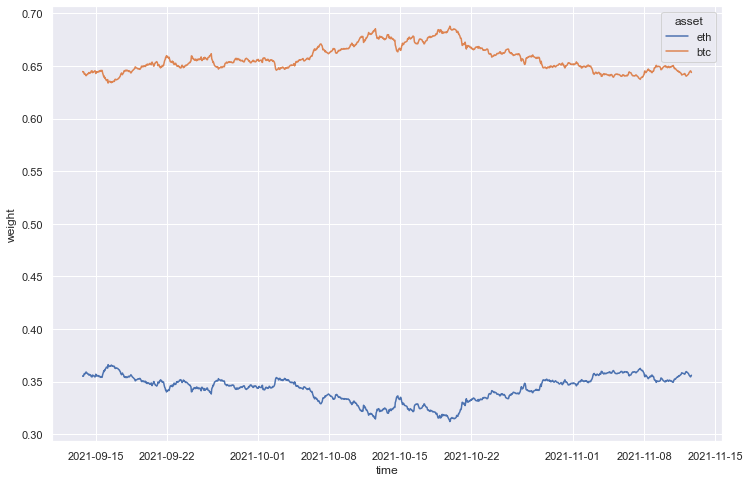

In [25]:
sns.lineplot(data=df_index_joined, x='time', y='weight', hue='asset')

In [26]:
df_index_melted = pd.melt(df_index_merged, id_vars='time', value_vars=['level', 'level_btc', 'level_eth'])
df_index_melted['variable'] = df_index_melted['variable'].map({'level': 'total', 'level_eth': 'eth', 'level_btc': 'btc'})

<AxesSubplot:xlabel='time', ylabel='value'>

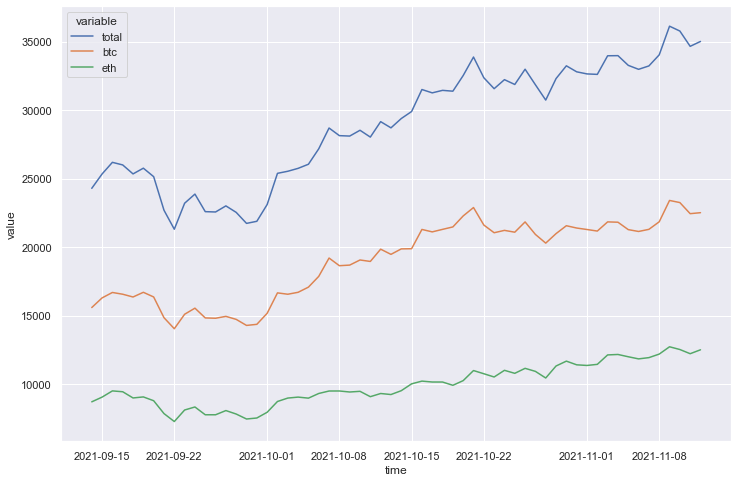

In [27]:
sns.lineplot(data=df_index_melted, x='time', y='value', hue='variable')


## Examples from State of the Network

The Python API Client is often used for transforming data for [State of the Network](https://coinmetrics.substack.com/). Below are some examples of data transformations done to produce the data visualizations.

### Example 1: Get returns by coin in the CM reference rates universe over the last 10-years
In [State of the Network #128](https://coinmetrics.substack.com/p/coin-metrics-state-of-the-network-53b), we looked at the returns for each asset dating back the last 10 years.

![returns-10-yr](https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F38b38adb-c4b7-43f6-a387-0cbae028861a_985x525.png)

We can generate this data by weaving in the `catalog_metrics` and `get_asset_metrics` endpoint. The code snippets below demonstrate how to do this with a small list of assets. 

In [28]:

# Get all assets that have a reference rate 
assets_refrate = client.catalog_metrics("ReferenceRateUSD")
# Get list of assets with daily ref rate 
# uncomment the top line to look at *every* asset with reference rates
# asset_with_ref_rates = assets_refrate[0]["frequencies"][0]["assets"]
asset_with_ref_rates = ['btc', 'eth', 'bnb', 'ada', 'doge', 'xrp']
#Query API for prices, daily CM reference rates as dataframe
metrics = "ReferenceRateUSD"
frequency = "1d"
start_time = "2011-11-08"
end_time = "2021-11-08"

logging.info("Getting prices...")
df_prices = client.get_asset_metrics(
    assets=asset_with_ref_rates,
    metrics=metrics,
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()
# Assign datatypes
df_prices["time"] = pd.to_datetime(df_prices.time)
df_prices["ReferenceRateUSD"] = df_prices.ReferenceRateUSD.astype(float)

# Reshape dataset so assets are in columns, dates are the rows, and the values are prices
df_prices_pivot = df_prices.pivot(
    index="time",
    columns="asset",
    values="ReferenceRateUSD"
)

# Index each asset's time series to 1 
for col in df_prices_pivot.columns:
    logging.info(f"Calculating Reference rate for {col}....")
    # First price in time series
    first_price = df_prices_pivot[df_prices_pivot[col].notnull()][col].iloc[0]
    # Index time series
    df_prices_pivot[col] = df_prices_pivot[col]/first_price
    # Fill forward for Null values
    df_prices_pivot[col] = df_prices_pivot[col].ffill()

2021-11-12 10:13:29 INFO     Getting prices...
2021-11-12 10:13:37 INFO     Calculating Reference rate for ada....
2021-11-12 10:13:37 INFO     Calculating Reference rate for bnb....
2021-11-12 10:13:37 INFO     Calculating Reference rate for btc....
2021-11-12 10:13:37 INFO     Calculating Reference rate for doge....
2021-11-12 10:13:37 INFO     Calculating Reference rate for eth....
2021-11-12 10:13:37 INFO     Calculating Reference rate for xrp....


In [29]:
df_prices_pivot.tail()

asset,ada,bnb,btc,doge,eth,xrp
time,,,,,,
2021-11-04 00:00:00+00:00,15.873724,7399.530246,20861.841236,174.621428,3832.408711,215.715393
2021-11-05 00:00:00+00:00,15.272089,7281.688268,20344.207965,170.562781,3779.699701,214.148949
2021-11-06 00:00:00+00:00,15.217889,7896.540025,20215.619395,169.160131,3730.778851,207.056617
2021-11-07 00:00:00+00:00,15.416958,8264.884998,20364.475877,169.947035,3759.733466,205.426072
2021-11-08 00:00:00+00:00,15.540748,8444.898474,20890.951359,172.724650,3841.107919,217.333231


### Example 2: Get daily spot trading volume on coinbase for all markets

In [State of the Network #126](https://coinmetrics.substack.com/p/coin-metrics-state-of-the-network-issue-126), we looked at spot volume on trusted exchanges over time.

![vol-over-time](https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F011acfa6-6b3e-4c51-bbc8-d0354235e005_1200x709.png)

We can replicate similar data behind chart using just coinbase spot markets at 2021. Here, we derive volume from our `get_market_candles` endpoint.

In [30]:
candles_coinbase = client.get_market_candles(
    markets="coinbase-*-spot", # wildcards can be passed to get all asset pairs
    start_time="2021-01-01",
    end_time="2021-10-29",
    frequency="1d"
).to_dataframe()
candles_coinbase["candle_usd_volume"] = candles_coinbase.candle_usd_volume.astype(float)
candles_coinbase["time"] = pd.to_datetime(candles_coinbase.time)

In [31]:
candles_coinbase.head()

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,coinbase-zen-btc-spot,2021-10-21 00:00:00+00:00,0.0012535999999999999,0.0013836,0.0013836,0.0012535999999999999,0.00131394046522898,2249.215,190959.982247,722
1,coinbase-zen-btc-spot,2021-10-22 00:00:00+00:00,0.001387,0.00143899999999999996,0.001439,0.0013581,0.001401907685406109,2182.331,187283.856132,605
2,coinbase-zen-btc-spot,2021-10-23 00:00:00+00:00,0.00143899999999999996,0.0014548,0.0014957,0.0014274,0.001461038796932774,765.643,68252.081037,402
3,coinbase-zen-btc-spot,2021-10-24 00:00:00+00:00,0.0014548,0.00150310000000000005,0.0015512,0.0014488,0.001520121952884886,587.285,54094.822641,438
4,coinbase-zen-btc-spot,2021-10-25 00:00:00+00:00,0.00150310000000000005,0.0014208,0.0015354,0.0014006,0.001470978992443325,782.09,71396.663073,402


We can also break this down by month. Note that for this example, the volume numbers will look smaller because we are using fewer exchanges.

![vol-by-month](https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fdd12c9e3-9728-478b-b8aa-7136f2aaae10_985x525.png)

In [32]:
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]


candles_coinbase.groupby(
    candles_coinbase.time.dt.month_name()
)[['candle_usd_volume']].sum().reindex(month_order).dropna()

,candle_usd_volume
time,
January,1.147053e+11
February,1.262543e+11
March,9.100767e+10
April,1.135328e+11
May,2.543443e+11
June,8.873852e+10
July,5.702550e+10
August,1.137132e+11
September,1.559313e+11
